In [193]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from chmp.ds import mpl_set


def softmax(logits):
    logits = logits - np.max(logits)
    p = np.exp(logits)
    return p / p.sum()

# Sequential Data

$$
\begin{aligned}
    p(x_{1:N}, z_{1:N}) &= 
        p(z_1) 
        \prod_{n=2}^N p(z_n|z_{n-1}) 
        \prod_{n=1}^N p(x_n|z_n)
\end{aligned}
$$

$$
\begin{aligned}
    \alpha(z_n) &= p(x_{1:n}, z_n)
    \beta(z_n) &= p(x_{n+1:N} | z_n)
\end{aligned}
$$

Boundary conditions:

$$
\begin{aligned}
    \alpha(z_1) &= p(z_1) p(x_1|z_1) \\
    \beta(z_N) &= 1 
\end{aligned}
$$

$$
\begin{aligned}
    p(x_{1:N}, z_n) &= \alpha(z_n) \beta(z_n) \\
    p(x_{1:N}) &= \sum_{z_n} \alpha(z_n) \beta(z_n) \\
        &= \sum_{z_N} \alpha(z_N)
\end{aligned}
$$

Strategy:

- use $\alpha$, $\beta$ to fit the model
- use $\alpha$ to predict

## Hidden Markov Models

Hidden Markov Models has discrete latent variables $z_{nk}$.

$$
    A_{jk} = p(z_{nk} = 1 | z_{n-1,j} = 1)
$$

$$
\begin{aligned}
    p(z_1) &= \prod_k \pi_k^{z_{1k}} \\
    p(z_n|z_{n-1}) &= \prod_k \prod_j A_{jk}^{z_{n-1,j} z_{nk}} \\
    p(x_n|z_n) &= p(x_n|z_n, \phi)
\end{aligned}
$$

In [100]:
K = 3
N = 10
P = 5

A = np.random.dirichlet((1.0,) * K, size=K)
pi = np.random.dirichlet((1.0,) * K)
mu = np.sort(np.random.normal(size=K))

z = np.zeros((N, P, K), dtype=np.int64)

idx = np.random.choice(np.arange(K), p=pi, size=P)
z[0, ...] = np.eye(K)[idx]

for n in range(1, N):
    for k in range(K):
        sel = z[n - 1, :, k] == 1
        idx = np.random.choice(np.arange(K), p=A[k], size=sel.sum())
        z[n, sel, :] = np.eye(K)[idx]
        
        
idx_n, idx_p, idx_k = np.nonzero(z)
x = np.zeros((N, P), dtype=np.float64)

x[idx_n, idx_p] = np.random.normal(mu[idx_k], scale=0.25)

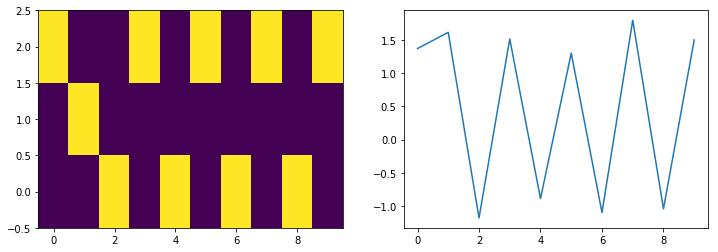

In [102]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(ax1)
plt.imshow(z[:, 1, :].T, origin='lower', aspect='auto')

plt.subplot(ax2)
plt.plot(x[:, 1])

$$
\begin{aligned}
    Q(\theta|\theta^\mathrm{old}) &= \sum_z p(z|X, \theta^\mathrm{old}) \ln p(z|X, \theta)
\end{aligned}
$$

Introduce:

$$
\begin{aligned}
    \gamma(z) &= p(z|x,\theta) \\
    \xi(z_{n-1},z_n) &= p(z_{n-1}, z_n, x, \theta)
\end{aligned}
$$

## Linear Dynamic Systems

- $\alpha$ recursion: Kalman filter
- $\beta$ recursion: Kalman smoothing

## Particle Filter

$$
\begin{aligned}
    \mathbb{E} \left[ f(z_n) \right] &\approx \sum_l w^{(l)}_n f(z^{(l)}_n) 
\\
    z^{(l)}_n &\sim p(z^{(l)}_n | x_{1:n-1})
\end{aligned}
$$

First sample a proposal for the latent state:

$$
\begin{aligned}
    z^{(l)}_1 &\sim p(z_1)
\\
    p(z^{(l)}_{n + 1} | x_{1:n}) &= 
        \sum_l w^{(l)}_n p(z_{n + 1}|z^{(l)}_n)
\end{aligned}
$$

Then, update the weight
$$
\begin{aligned}
    w^{(l)}_n &= \frac{
        p(x_n|z_n^{(l)}) 
    }{
        \sum_l p(x_n|z_n^{(l)}) 
    }
\end{aligned}
$$

In [198]:
N = 60
D = 2
P = 10

standard_normal = scipy.stats.norm(0, 1)

# simulate random data
v = np.asarray([0.5, 0.5])
z = np.zeros((N, D)) 

z[0, :] = np.random.normal(0, 1, size=D)
for n in range(1, N):
    z[n, :] = z[n -1, :] + v + np.random.normal(0, 1, size=D)

x = z + np.random.normal(0, 1, size=(N, D))

# compute particle filter
particle_z = np.zeros((N, P, D))
particle_w = np.zeros((N, P))
particle_c = np.zeros((N, P), dtype=np.int64)

particle_z[0, ...] = standard_normal.rvs(size=(P, D))

particle_w[0, :] = standard_normal.logpdf(x[0, None, :] - particle_z[0, ...]).sum(axis=1)
particle_w[0, :] = softmax(particle_w[0, :])

for n in range(1, N):

    particle_c[n, :] = np.random.choice(np.arange(P), size=P, p=particle_w[n - 1, :])
    particle_z[n, ...] = particle_z[n - 1, particle_c[n, :]] + v + standard_normal.rvs(size=(P, D))
    
    particle_w[n, :] = standard_normal.logpdf(x[n, None, :] - particle_z[n, ...]).sum(axis=1)
    particle_w[n, :] = softmax(particle_w[n, :])


# determine the mean
filtered_z = np.sum(particle_w[..., None] * particle_z, axis=1)

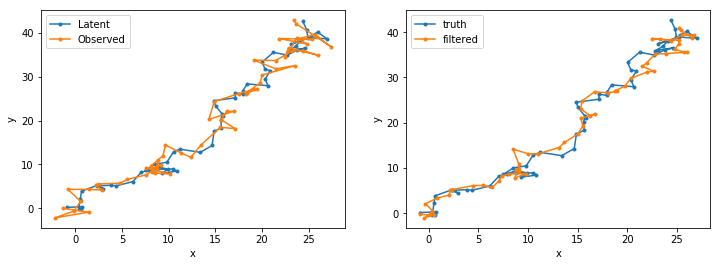

In [199]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(ax1)
plt.plot(z[:, 0], z[:, 1], '.-', label='Latent')
plt.plot(x[:, 0], x[:, 1], '.-', label='Observed')
mpl_set(xlabel='x', ylabel='y', legend=True)

plt.subplot(ax2)
plt.plot(z[:, 0], z[:, 1], '.-', label='truth')
plt.plot(filtered_z[:, 0], filtered_z[:, 1], '.-', label='filtered')
mpl_set(xlabel='x', ylabel='y', legend=True)